# Denoising by proximal solvers - as in Chambolle paper

We try to solve the following problem (as in Pock and Chambolle paper):

$$
arg \;  min_\mathbf{u} \frac{\lambda}{2}||\mathbf{u-f}||_2^2 + J(\mathbf{u})
$$

with different choices of regularization:

- L2 on Gradient $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_2^2$
- Anisotropic TV $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_1$
- Anisotropic TV + Bregman iterations $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_1 - \mathbf{p}_k^T \mathbf{u}$
- Isotropic TV $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_{2,1}$
- Isotropic TV + Bregman iterations $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_{2,1} - \mathbf{p}_k^T \mathbf{u}$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy import misc
from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *

In [2]:
def callback(x):
    mhist.append(x)

Data and operators preparation

In [3]:
# Load image
img = misc.ascent()
img = img/np.max(img)
ny, nx = img.shape

# Add noise
sigman = 0.2
n = sigman*np.max(abs(img.ravel()))*np.random.uniform(-1,1, img.shape)
#n = np.random.normal(0, sigman, img.shape)
noise_img = img + n

In [4]:
# Gradient operator
sampling = 1.
Gop = Gradient(dims=(ny, nx), sampling=sampling, edge=False, 
               kind='forward', dtype='float64')

# Data term scaling
lamda = 8.

### L2 on Gradient

here
here


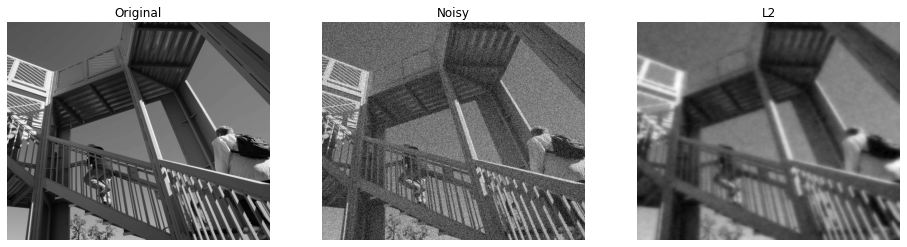

In [5]:
# L2 data term
l2 = L2(b=noise_img.ravel(), sigma=lamda)

# L2 regularization
sigma = 100.
thik = L2(sigma=sigma)

L = 8. / sampling**2 # maxeig(Grad^H Grad)
tau = 1.
mu = 1. / (tau*L)

iml2 = LinearizedADMM(l2, thik, Gop, tau=tau, mu=mu, x0=np.zeros_like(img.ravel()), 
                      niter=100)[0]
iml2 = iml2.reshape(img.shape)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(noise_img, cmap='gray')
axs[1].set_title('Noisy')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(iml2, cmap='gray')
axs[2].set_title('L2')
axs[2].axis('off')
axs[2].axis('tight');

### Anisotropic TV

In [6]:
# L2 data term
l2 = L2(b=noise_img.ravel(), sigma=lamda)

# Anisotropic TV
l1 = L1()

L = 8. / sampling**2 # maxeig(Grad^H Grad)
tau = 1.
mu = tau / L

iml1 = LinearizedADMM(l2, l1, Gop, tau=tau, mu=mu, 
                      x0=np.zeros_like(img.ravel()), 
                      niter=100)[0]
iml1 = iml1.reshape(img.shape)

here


### Anisotropic TV + Bregman iterations

In [7]:
# L2 data term
sigma = 10.
l2 = L2(b=noise_img.ravel(), sigma=lamda, alpha=sigma, qgrad=False)

# Anisotropic TV
l1 = L1(sigma=sigma)

L = 8. / sampling**2 # maxeig(Grad^H Grad)
tau = 1.
mu = tau / L

iml1b = Bregman(l2, l1, A=Gop, x0=np.zeros_like(img.ravel()), 
                solver=LinearizedADMM, niterouter=10,
                **dict(tau=tau, mu=mu, niter=50))
iml1b = iml1b.reshape(img.shape)

### Isotropic TV with Primal-Dual

In [8]:
# L2 data term
l2 = L2(b=noise_img.ravel(), sigma=lamda)

# L1 regularization (isotropic TV)
l1iso = L21(ndim=2)

# Primal-dual
L =  8. / sampling**2 # maxeig(Grad^H Grad)
tau = 0.01
mu = 1. / (tau*L)

iml12 = PrimalDual(l2, l1iso, Gop, tau=tau, mu=mu, theta=1., 
                   x0=np.zeros_like(img.ravel()), 
                   niter=400, show=True)
iml12 = iml12.reshape(img.shape)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau = 1.000000e-02	mu = 1.250000e+01
theta = 1.00		niter = 400

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   2.67700e-02   1.506e+05   4.286e+03   0.000e+00       1.548e+05
     2   5.22022e-02   1.311e+05   4.083e+03   0.000e+00       1.351e+05
     3   7.54612e-02   1.149e+05   3.506e+03   0.000e+00       1.184e+05
     4   9.60814e-02   1.011e+05   3.232e+03   0.000e+00       1.043e+05
     5   1.14181e-01   8.910e+04   3.224e+03   0.000e+00       9.232e+04
     6   1.30056e-01   7.874e+04   3.311e+03   0.000e+00       8.206e+04
     7   1.44075e-01   6.979e+04   3.425e+03   0.000e+00       7.321e+04
     8   1.56676e-01   6.206e+04   3

### Isotropic TV + Bregman iterations

In [9]:
sigma = 10.
l2 = L2(b=noise_img.ravel(), sigma=lamda, alpha=sigma, qgrad=False)

# L1 regularization (isotropic TV)
l1iso = L21(ndim=2, sigma=sigma)

# Primal-dual
L =  8. / sampling**2 # maxeig(Grad^H Grad)
#tau = 1 / np.sqrt(L)
#mu = 1 / np.sqrt(L)
tau = 0.01
mu = 1. / (tau*L)

iml12b = Bregman(l2, l1iso, A=Gop, x0=np.zeros_like(img.ravel()), 
                 solver=PrimalDual, niterouter=10,
                 **dict(tau=tau, mu=mu, theta=1., niter=50))
iml12b = iml12b.reshape(img.shape)

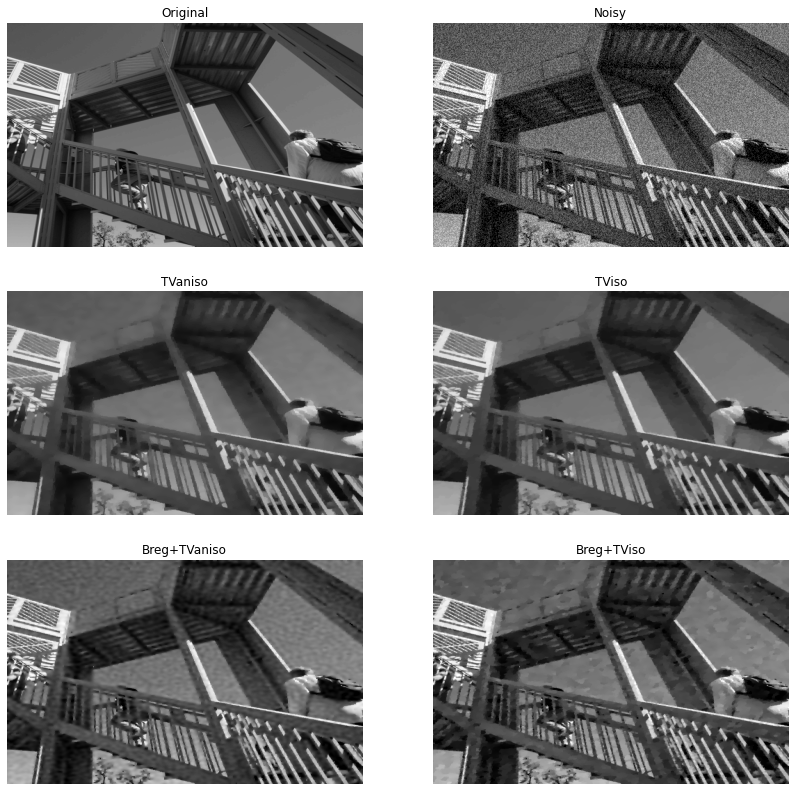

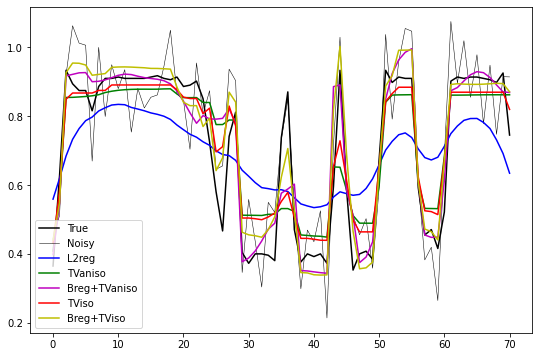

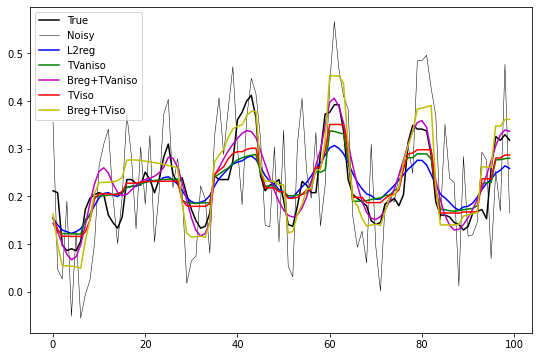

In [10]:
fig, axs = plt.subplots(3, 2, figsize=(14, 14))
axs[0][0].imshow(img, cmap='gray', vmin=0, vmax=1)
axs[0][0].set_title('Original')
axs[0][0].axis('off')
axs[0][0].axis('tight')
axs[0][1].imshow(noise_img, cmap='gray', vmin=0, vmax=1)
axs[0][1].set_title('Noisy')
axs[0][1].axis('off')
axs[0][1].axis('tight')
axs[1][0].imshow(iml1, cmap='gray', vmin=0, vmax=1)
axs[1][0].set_title('TVaniso')
axs[1][0].axis('off')
axs[1][0].axis('tight')
axs[1][1].imshow(iml12, cmap='gray', vmin=0, vmax=1)
axs[1][1].set_title('TViso')
axs[1][1].axis('off')
axs[1][1].axis('tight');
axs[2][0].imshow(iml1b, cmap='gray', vmin=0, vmax=1)
axs[2][0].set_title('Breg+TVaniso')
axs[2][0].axis('off')
axs[2][0].axis('tight')
axs[2][1].imshow(iml12b, cmap='gray', vmin=0, vmax=1)
axs[2][1].set_title('Breg+TViso')
axs[2][1].axis('off')
axs[2][1].axis('tight')

ix_min = 84
ix_max = 155
iy = 20
plt.figure(figsize=(9, 6))
plt.plot(img[ix_min:ix_max, iy], 'k', label='True')
plt.plot(noise_img[ix_min:ix_max, iy], 'k', lw=0.5, label='Noisy')
plt.plot(iml2[ix_min:ix_max, iy], 'b', label='L2reg')
plt.plot(iml1[ix_min:ix_max, iy], 'g', label='TVaniso')
plt.plot(iml1b[ix_min:ix_max, iy], 'm', label='Breg+TVaniso')
plt.plot(iml12[ix_min:ix_max, iy], 'r', label='TViso')
plt.plot(iml12b[ix_min:ix_max, iy], 'y', label='Breg+TViso')
plt.legend();

ix = 50
iy_min = 250
iy_max = 350
plt.figure(figsize=(9, 6))
plt.plot(img[ix, iy_min:iy_max], 'k', label='True')
plt.plot(noise_img[ix, iy_min:iy_max], 'k', lw=0.5, label='Noisy')
plt.plot(iml2[ix, iy_min:iy_max], 'b', label='L2reg')
plt.plot(iml1[ix, iy_min:iy_max], 'g', label='TVaniso')
plt.plot(iml1b[ix, iy_min:iy_max], 'm', label='Breg+TVaniso')
plt.plot(iml12[ix, iy_min:iy_max], 'r', label='TViso')
plt.plot(iml12b[ix, iy_min:iy_max], 'y', label='Breg+TViso')
plt.legend();

## Salt and Pepper noise

At this point we have considered random noise. We will deal now with salt and pepper noise (which is 0 and 1 spikes added randomly to the image.

It turns out that in this case switching from a L2 norm to a L1 norm on the data term can be used to further improve our denoising capabilities:


$$
arg \;  min_\mathbf{u} \lambda||\mathbf{u-f}||_1 + J(\mathbf{u})
$$

In [11]:
# Load image
img = misc.ascent()
#img = 2*img/np.max(img) - 1.
img = img/np.max(img)
ny, nx = img.shape

# Add salt and pepper noise
noiseperc = 0.1

isalt = np.random.permutation(np.arange(ny*nx))[:int(noiseperc*ny*nx)]
ipepper = np.random.permutation(np.arange(ny*nx))[:int(noiseperc*ny*nx)]
noise_img = img.copy().ravel()
noise_img[isalt] = img.max()
noise_img[ipepper] = img.min()
noise_img = noise_img.reshape(ny,nx)

In [12]:
# Gradient operator
sampling = 1.
Gop = Gradient(dims=(ny, nx), sampling=sampling, edge=False, 
               kind='forward', dtype='float64')

### L2 data norm with Isotropic TV

In [13]:
# L2 data term
lamda = 4.
l2 = L2(b=noise_img.ravel(), sigma=lamda)

# L1 regularization (isotropic TV)
l1iso = L21(ndim=2)

# Primal-dual
L =  8. / sampling**2 # maxeig(Grad^H Grad)
#tau = 1 / np.sqrt(L)
#mu = 1 / np.sqrt(L)
tau = .1
mu = 1. / (tau*L)

iml12_l2 = PrimalDual(l2, l1iso, Gop, tau=tau, mu=mu, theta=1., x0=np.zeros_like(noise_img).ravel(), 
                      niter=400, show=True)
iml12_l2 = iml12_l2.reshape(img.shape)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau = 1.000000e-01	mu = 1.250000e+00
theta = 1.00		niter = 400

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   2.85714e-01   5.747e+04   2.306e+04   0.000e+00       8.053e+04
     2   4.20768e-01   3.703e+04   2.385e+04   0.000e+00       6.088e+04
     3   4.85249e-01   2.936e+04   1.985e+04   0.000e+00       4.921e+04
     4   5.31309e-01   2.672e+04   1.584e+04   0.000e+00       4.256e+04
     5   5.64212e-01   2.604e+04   1.297e+04   0.000e+00       3.901e+04
     6   5.87715e-01   2.602e+04   1.108e+04   0.000e+00       3.709e+04
     7   6.04500e-01   2.616e+04   9.779e+03   0.000e+00       3.594e+04
     8   6.16488e-01   2.631e+04   8

### L1 data norm with Isotropic TV

In [14]:
# L1 data term
lamda = 1.5
l1 = L1(g=noise_img.ravel(), sigma=lamda)

# L1 regularization (isotropic TV)
l1iso = L21(ndim=2)

# Primal-dual
L =  8. / sampling**2 # maxeig(Grad^H Grad)
#tau = 1 / np.sqrt(L)
#mu = 1 / np.sqrt(L)
tau = 1.
mu = 1. / (tau*L)

iml12_l1 = PrimalDual(l1, l1iso, Gop, tau=tau, mu=mu, theta=1., 
                      x0=np.zeros_like(noise_img).ravel(), #x0=noise_img.ravel(), 
                      niter=100, show=True)
iml12_l1 = iml12_l1.reshape(img.shape)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L1.L1'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   1.00000e+00   1.446e+05   8.072e+04   0.000e+00       2.253e+05
     2   1.00000e+00   1.446e+05   8.072e+04   0.000e+00       2.253e+05
     3   1.00000e+00   1.446e+05   8.072e+04   0.000e+00       2.253e+05
     4   1.00000e+00   1.428e+05   7.575e+04   0.000e+00       2.186e+05
     5   1.00000e+00   1.376e+05   6.021e+04   0.000e+00       1.978e+05
     6   1.00000e+00   1.323e+05   4.684e+04   0.000e+00       1.791e+05
     7   1.00000e+00   1.292e+05   4.079e+04   0.000e+00       1.700e+05
     8   1.00000e+00   1.277e+05   3

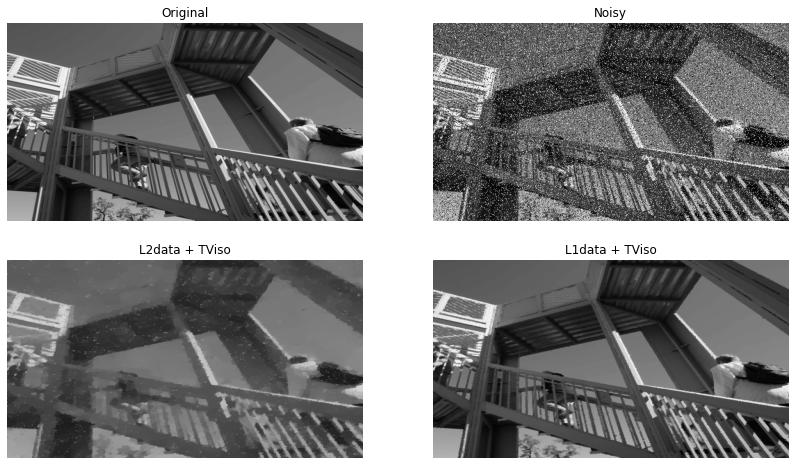

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs[0][0].imshow(img, cmap='gray', vmin=0, vmax=1)
axs[0][0].set_title('Original')
axs[0][0].axis('off')
axs[0][0].axis('tight')
axs[0][1].imshow(noise_img, cmap='gray', vmin=0, vmax=1)
axs[0][1].set_title('Noisy')
axs[0][1].axis('off')
axs[0][1].axis('tight')
axs[1][0].imshow(iml12_l2, cmap='gray', vmin=0, vmax=1)
axs[1][0].set_title('L2data + TViso')
axs[1][0].axis('off')
axs[1][0].axis('tight')
axs[1][1].imshow(iml12_l1, cmap='gray', vmin=0, vmax=1)
axs[1][1].set_title('L1data + TViso')
axs[1][1].axis('off')
axs[1][1].axis('tight');